<a href="https://colab.research.google.com/github/AlessandraParziale/Fairness-Thesis/blob/main/BANK_MARKETING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BANK MARKETING**
[Questi dati sono relativi alle campagne di marketing di un istituto bancario portoghese. Le campagne di marketing erano basate su telefonate. Spesso era necessario più di un contatto con lo stesso cliente per poter affermare se il prodotto sarebbe stato ('sì') o meno ('no') sottoscritto.]

## ***Classification***

### Loading the Data

In [ ]:
import os
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder



In [ ]:
DATA_DIR = "/content/BANK_MARKETING-Classification"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

def load_bank_marketing():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
    fname = "bank-marketing.csv"
    fpath = f"{DATA_DIR}/{fname}"

    if not os.path.isfile(fpath):
        r = requests.get(url)
        with open("tempdataset.zip", "wb") as f:
            f.write(r.content)

        with ZipFile("tempdataset.zip", "r") as z:
            z.extract("bank-additional/bank-additional-full.csv")
            df = pd.read_csv(z.open("bank-additional/bank-additional-full.csv"), delimiter=";", encoding="utf-8")
            df.to_csv(fpath, index=False)

        os.remove("tempdataset.zip")

    df = pd.read_csv(fpath)
    df['job'] = df['job'].values
    df = df.astype({'job': 'category', 'y': 'category'})

    df = df.dropna()

    X = df.drop(columns=['y'])
    y = df['y']

    y.cat.set_categories(['yes', 'no'], ordered=True, inplace=True)

    print(X)
    num_colonne_X = X.shape[1]
    print("Numero di colonne nel DataFrame X:", num_colonne_X)

    return X, y


X, y = load_bank_marketing()


       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

<ipython-input-3-895d95ce60f7>:32: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  y.cat.set_categories(['yes', 'no'], ordered=True, inplace=True)


In [ ]:
# Trasformazione variabili categoriche in numeri


categorical_cols = X.select_dtypes(include=['category', 'object']).columns

label_encoder = LabelEncoder()

for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

print(X.head())


   age  job  marital  education  default  housing  loan  contact  month  \
0   56    3        1          0        0        0     0        1      6   
1   57    7        1          3        1        0     0        1      6   
2   37    7        1          3        0        2     0        1      6   
3   40    0        1          1        0        0     0        1      6   
4   56    7        1          3        0        0     2        1      6   

   day_of_week  duration  campaign  pdays  previous  poutcome  emp.var.rate  \
0            1       261         1    999         0         1           1.1   
1            1       149         1    999         0         1           1.1   
2            1       226         1    999         0         1           1.1   
3            1       151         1    999         0         1           1.1   
4            1       307         1    999         0         1           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0          93.9

----
### **Random Perturbation with Random Forest**

In [ ]:
# Random Forest sul dataset originale

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_original = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original.fit(X_train, y_train)


# Valutazione

# Accuracy
original_accuracy = accuracy_score(y_test, rf_original.predict(X_test))
print("Accuracy original dataset:", original_accuracy)

# Precision
original_precision = precision_score(y_test, rf_original.predict(X_test), pos_label='yes')
print("Precision original dataset:", original_precision)

# Recall
original_recall = recall_score(y_test, rf_original.predict(X_test), pos_label='yes')
print("Recall original dataset:", original_recall)

Accuracy original dataset: 0.9133284777858703
Precision original dataset: 0.649932157394844
Recall original dataset: 0.5122994652406417


In [ ]:
# Dataset con Random Perturbation

n_perturbations = 6
perturbed_datasets = []
for _ in range(n_perturbations):
    perturbed_X = X_train.copy()
    perturbed_X += np.random.normal(loc=0, scale=0.01, size=perturbed_X.shape)
    perturbed_datasets.append(perturbed_X)

In [ ]:
# Random Forest + Valutazione di tutti i dataset con Random Perturbation

perturbed_accuracies = []
perturbed_precisions = []
perturbed_recalls = []

for perturbed_X in perturbed_datasets:
    rf_perturbed = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_perturbed.fit(perturbed_X, y_train)

    perturbed_accuracy = accuracy_score(y_test, rf_perturbed.predict(X_test))
    perturbed_accuracies.append(perturbed_accuracy)

    perturbed_precision = precision_score(y_test, rf_perturbed.predict(X_test), pos_label='yes')
    perturbed_precisions.append(perturbed_precision)

    perturbed_recall = recall_score(y_test, rf_perturbed.predict(X_test), pos_label='yes')
    perturbed_recalls.append(perturbed_recall)

mean_perturbed_accuracy = np.mean(perturbed_accuracies)
print("Accuracy datasets with Random Perturbation:", mean_perturbed_accuracy)
mean_perturbed_precision = np.mean(perturbed_precision)
print("Precision datasets with Random Perturbation:", mean_perturbed_precision)
mean_perturbed_recall = np.mean(perturbed_recall)
print("Recall datasets with Random Perturbation:", mean_perturbed_recall)



Accuracy datasets with Random Perturbation: 0.9162418062636563
Precision datasets with Random Perturbation: 0.6829268292682927
Recall datasets with Random Perturbation: 0.509090909090909


## ***Clustering***

### Loading the Data

In [ ]:
import os
import pandas as pd
import requests

from zipfile import ZipFile
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist

In [ ]:
DATA_DIR = "/content/BANK_MARKETING-Clustering"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

def load_bank_marketing():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
    fname = "bank-marketing.csv"
    fpath = f"{DATA_DIR}/{fname}"

    if not os.path.isfile(fpath):
        r = requests.get(url)
        with open("tempdataset.zip", "wb") as f:
            f.write(r.content)

        with ZipFile("tempdataset.zip", "r") as z:
            z.extract("bank-additional/bank-additional-full.csv")
            df = pd.read_csv(z.open("bank-additional/bank-additional-full.csv"), delimiter=";", encoding="utf-8")
            df.to_csv(fpath, index=False)

        os.remove("tempdataset.zip")

    df = pd.read_csv(fpath)

    X = df.dropna()
    print(X.head())

    return X


X = load_bank_marketing()



   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

In [ ]:
# Trasformazione variabili categoriche in numeri


categorical_cols = X.select_dtypes(include=['category', 'object']).columns

label_encoder = LabelEncoder()

for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

num_colonne_X = X.shape[1]
print("Numero di colonne nel DataFrame X dopo l'encoding:", num_colonne_X)

print(X.head())


Numero di colonne nel DataFrame X dopo l'encoding: 21
   age  job  marital  education  default  housing  loan  contact  month  \
0   56    3        1          0        0        0     0        1      6   
1   57    7        1          3        1        0     0        1      6   
2   37    7        1          3        0        2     0        1      6   
3   40    0        1          1        0        0     0        1      6   
4   56    7        1          3        0        0     2        1      6   

   day_of_week  ...  campaign  pdays  previous  poutcome  emp.var.rate  \
0            1  ...         1    999         0         1           1.1   
1            1  ...         1    999         0         1           1.1   
2            1  ...         1    999         0         1           1.1   
3            1  ...         1    999         0         1           1.1   
4            1  ...         1    999         0         1           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.em

---
### **K-means**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

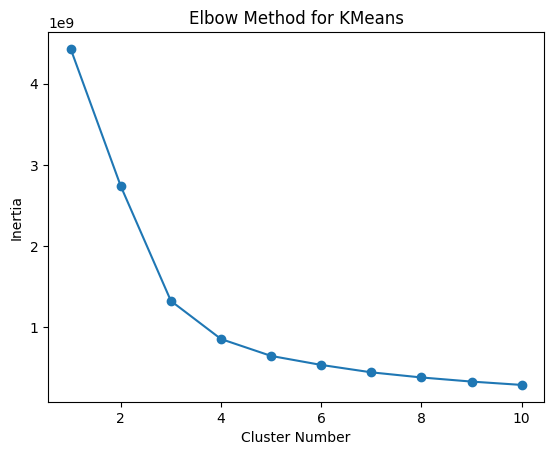

In [ ]:
# Metodo del gomito (Elbow Method)


inertia = []
k_values = range(1, 11)

# Calcolo inertia per ogni valore di k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Grafico
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans')
plt.show()


In [ ]:
# K-Means con 4 cluster

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

labels = kmeans.labels_
print(labels)


# Valutazione modello

# Coefficiente di Silhouette
silhouette_coefficient = silhouette_score(X, labels)
print("Il coefficiente di Silhouette è:", silhouette_coefficient)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[3 3 3 ... 3 0 3]
Il coefficiente di Silhouette è: 0.5650492077260703


---
 ### **K-Center**

In [ ]:
# K-Center con 4 cluster

def kcenter(X, k):
    centers = [X.to_numpy()[0]]
    while len(centers) < k:
        #Calcolo distanze
        distances = cdist(X.to_numpy(), centers).min(axis=1)
        #Selezione nuovo centro
        new_center = X.to_numpy()[np.argmax(distances)]
        # Aggiunta nuovo centro alla lista
        centers.append(new_center)
    return np.array(centers)

k = 4
cluster_centers = kcenter(X, k)

def assign_clusters(X, cluster_centers):
    #Distanze tra ogni punto e tutti i centri dei cluster
    distances = cdist(X.to_numpy(), cluster_centers)
    #Trovo l'indice del centro più vicino per ciascun punto
    cluster_indices = np.argmin(distances, axis=1)

    return cluster_indices


labels = assign_clusters(X, cluster_centers)
print(labels)


# Valutazione modello

# Coefficiente di Silhouette
silhouette_coefficient = silhouette_score(X, labels)
print("Il coefficiente di Silhouette è:", silhouette_coefficient)


[0 0 0 ... 0 0 0]
Il coefficiente di Silhouette è: 0.7257280483073265


---
 ### **K-Median**

In [ ]:
# K-Median con 4 cluster

def k_median(X, k, max_iters=100):
    #Inizializzazione casuale
    centroids = X[np.random.choice(range(len(X)), size=k, replace=False)]

    for _ in range(max_iters):
        #Calcolo distanza tra ogni punto e ogni centroide
        distances = np.linalg.norm(X[:, np.newaxis, :] - centroids, axis=2)
        #Indice del centroide più vicino per ogni punto
        labels = np.argmin(distances, axis=1)
        #Calcolo i nuovi centroidi come mediane dei punti assegnati a ciascun cluster
        new_centroids = np.array([np.median(X[labels == i], axis=0) for i in range(k)])

        if np.allclose(new_centroids, centroids):
            break

        centroids = new_centroids

    return centroids, labels

centroids, labels = k_median(X.values, k=4)
print(labels)


# Valutazione modello

# Coefficiente di Silhouette
silhouette_coefficient = silhouette_score(X, labels)
print("Il coefficiente di Silhouette è:", silhouette_coefficient)


[2 2 2 ... 2 3 2]
Il coefficiente di Silhouette è: 0.2775141931282663
